## Exercice 1 : FFT non récursive

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft as scipy_fft
import time

In [10]:
def bit_reverse_copy(x):
    """Copie le vecteur x dans l'ordre bit-reverse"""
    N = len(x)
    nbits = int(np.log2(N))

    # Création d'un tableau d'indices bit-reverse
    indices = np.zeros(N, dtype=int)
    for i in range(N):
        # Reverse les bits de i
        rev = 0
        for j in range(nbits):
            if (i >> j) & 1:
                rev |= 1 << (nbits - 1 - j)
        indices[i] = rev

    return x[indices]

def fft_non_recursive(x):
    """
    Implémentation non récursive de la FFT (Cooley-Tukey)
    Entrée: x - vecteur complexe de taille N=2^m
    Sortie: transformée de Fourier discrète
    """
    N = len(x)
    m = int(np.log2(N))

    # Vérifier que N est une puissance de 2
    if 2**m != N:
        raise ValueError("La taille doit être une puissance de 2")

    # Étape 1: Réarrangement bit-reverse
    X = bit_reverse_copy(x).astype(complex)

    # Étape 2: Butterfly computation
    for s in range(1, m + 1):
        m_s = 2**s
        w_m_s = np.exp(-2j * np.pi / m_s)

        for k in range(0, N, m_s):
            w = 1
            for j in range(m_s // 2):
                t = w * X[k + j + m_s // 2]
                u = X[k + j]
                X[k + j] = u + t
                X[k + j + m_s // 2] = u - t
                w *= w_m_s

    return X

def ifft_non_recursive(X):
    """
    Implémentation non récursive de l'IFFT (inverse Cooley-Tukey)
    Entrée: X - vecteur complexe de taille N=2^m
    Sortie: transformée de Fourier inverse discrète
    """
    N = len(X)
    x = fft_non_recursive(np.conjugate(X)) # FFT du conjugué
    return np.conjugate(x) / N # Conjuguer et diviser par N

def test_fft():
    """Test et validation de la FFT"""

    # Test 1: Sinusoïde simple
    N = 64
    t = np.linspace(0, 1, N, endpoint=False)
    f = 5  # Fréquence
    x = np.sin(2 * np.pi * f * t)

    # Calcul avec notre FFT
    start = time.time()
    X_custom = fft_non_recursive(x)
    time_custom = time.time() - start

    # Calcul avec scipy
    start = time.time()
    X_scipy = scipy_fft(x)
    time_scipy = time.time() - start

    # Comparaison
    error = np.max(np.abs(X_custom - X_scipy))

    print(f"Test FFT - N = {N}")
    print(f"Temps custom: {time_custom:.6f} s")
    print(f"Temps scipy: {time_scipy:.6f} s")
    print(f"Erreur maximale: {error:.2e}")

    # Test 2: Impulsion de Dirac discrète
    x2 = np.zeros(N)
    x2[0] = 1
    X2_custom = fft_non_recursive(x2)
    X2_scipy = scipy_fft(x2)
    error2 = np.max(np.abs(X2_custom - X2_scipy))
    print(f"\nTest Dirac - Erreur: {error2:.2e}")

    # Test 3: Signal aléatoire
    x3 = np.random.randn(N) + 1j * np.random.randn(N)
    X3_custom = fft_non_recursive(x3)
    X3_scipy = scipy_fft(x3)
    error3 = np.max(np.abs(X3_custom - X3_scipy))
    print(f"Test aléatoire - Erreur: {error3:.2e}")

    return error < 1e-10

test_fft()

Test FFT - N = 64
Temps custom: 0.000264 s
Temps scipy: 0.000156 s
Erreur maximale: 1.80e-14

Test Dirac - Erreur: 0.00e+00
Test aléatoire - Erreur: 1.60e-14


np.True_

## Exercice 2 : Matrices circulantes

In [12]:
class MatriceCirculante:
    """Classe pour les matrices circulantes"""

    def __init__(self, c):
        """
        Initialise une matrice circulante
        c: première ligne de la matrice
        """
        self.c = np.array(c, dtype=complex)
        self.N = len(c)

    def matmul(self, x):
        """Multiplication matrice-vecteur Ax"""
        # Utilisation de la convolution circulaire
        return self.convolution_circulante(x)  # CORRECTION ICI

    def convolution_circulante(self, x):
        """Calcule la convolution circulante c * x"""
        N = self.N
        # Méthode directe pour la convolution circulante
        result = np.zeros(N, dtype=complex)
        for i in range(N):
            for j in range(N):
                result[i] += self.c[(i - j) % N] * x[j]
        return result

    def convolution_circulante_fft(self, x):
        """Version optimisée utilisant FFT"""
        # Pour une convolution circulante : c * x = IFFT(FFT(c) * FFT(x))
        C = fft_non_recursive(self.c)
        X = fft_non_recursive(x)
        Y = C * X
        y = ifft_non_recursive(Y)  # IFFT via FFT
        return y

    def valeurs_propres(self):
        """Calcule les valeurs propres de la matrice circulante"""
        # Les valeurs propres sont la FFT de la première ligne
        return fft_non_recursive(self.c)

    def vecteurs_propres(self):
        """Calcule les vecteurs propres de la matrice circulante"""
        N = self.N
        # Les vecteurs propres sont les colonnes de la matrice de Fourier
        F = np.zeros((N, N), dtype=complex)
        for k in range(N):
            for j in range(N):
                F[k, j] = np.exp(-2j * np.pi * j * k / N)
        return F / np.sqrt(N)

    def solve(self, b):
        """
        Résout Ax = b en utilisant la diagonalisation par FFT
        """
        # Transformée de Fourier de b
        b_hat = fft_non_recursive(b)

        # Valeurs propres (FFT de c)
        lambda_k = fft_non_recursive(self.c)

        # Solution dans le domaine fréquentiel
        # Attention aux valeurs propres nulles
        eps = 1e-12
        lambda_k_safe = np.where(np.abs(lambda_k) < eps, eps, lambda_k)
        x_hat = b_hat / lambda_k_safe

        # Transformée inverse
        x = ifft_non_recursive(x_hat)

        return x

    def to_matrix(self):
        """Convertit en matrice explicite (pour vérification)"""
        N = self.N
        A = np.zeros((N, N), dtype=complex)
        for i in range(N):
            for j in range(N):
                A[i, j] = self.c[(i - j) % N]
        return A

def test_matrice_circulante():
    """Test des opérations sur les matrices circulantes"""

    N = 8
    # Création d'une matrice circulante aléatoire
    c = np.random.randn(N) + 1j * np.random.randn(N)
    A = MatriceCirculante(c)

    # Test multiplication (version directe)
    x = np.random.randn(N) + 1j * np.random.randn(N)
    b1 = A.matmul(x)

    # Vérification avec la matrice explicite
    A_mat = A.to_matrix()
    b2 = A_mat @ x

    error = np.max(np.abs(b1 - b2))
    print(f"Test multiplication matrice-vecteur (direct): erreur = {error:.2e}")

    # Test multiplication (version FFT)
    b3 = A.convolution_circulante_fft(x)
    error_fft = np.max(np.abs(b2 - b3))
    print(f"Test multiplication (FFT): erreur = {error_fft:.2e}")

    # Test valeurs propres
    lambda_calc = A.valeurs_propres()
    lambda_true = np.linalg.eigvals(A_mat)

    # Tri et comparaison
    lambda_calc_sorted = np.sort(lambda_calc)
    lambda_true_sorted = np.sort(lambda_true)
    error_eig = np.max(np.abs(lambda_calc_sorted - lambda_true_sorted))
    print(f"Test valeurs propres: erreur = {error_eig:.2e}")

    # Test résolution
    b = np.random.randn(N) + 1j * np.random.randn(N)
    x_sol = A.solve(b)
    b_check = A.matmul(x_sol)
    error_solve = np.max(np.abs(b - b_check))
    print(f"Test résolution Ax=b: erreur = {error_solve:.2e}")

    return error < 1e-10 and error_eig < 1e-10 and error_solve < 1e-8

test_matrice_circulante()

Test multiplication matrice-vecteur (direct): erreur = 9.93e-16
Test multiplication (FFT): erreur = 1.99e-15
Test valeurs propres: erreur = 4.31e-15
Test résolution Ax=b: erreur = 6.28e-16


np.True_

## Exercice 3 : Problème 1D -u'' = f


Test avec f(x) = sin(x)
Erreur relative max: 8.16e-04


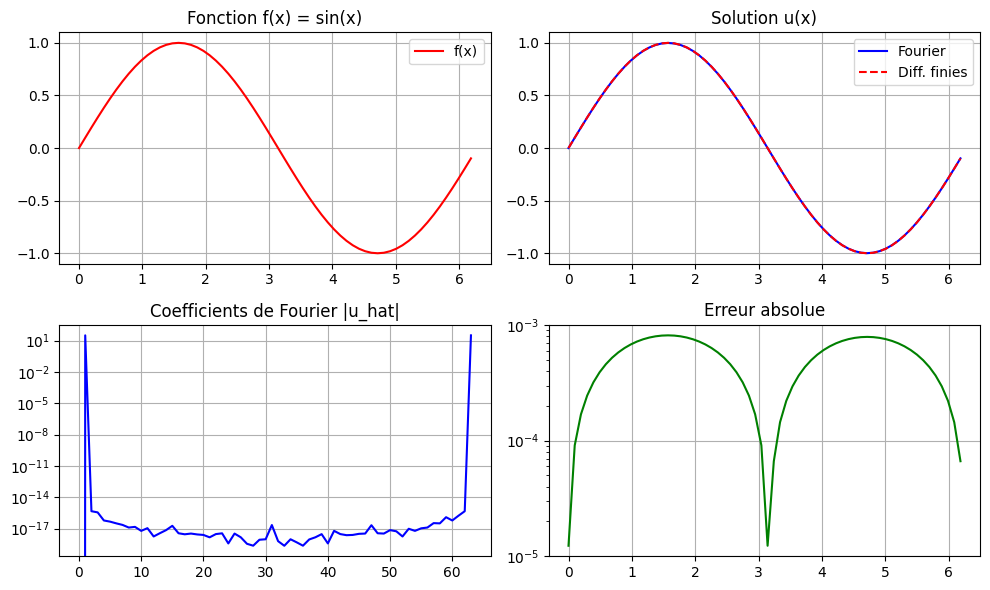


Test avec f(x) = sin(3x)+0.5cos(5x)
Erreur relative max: 1.01e-02


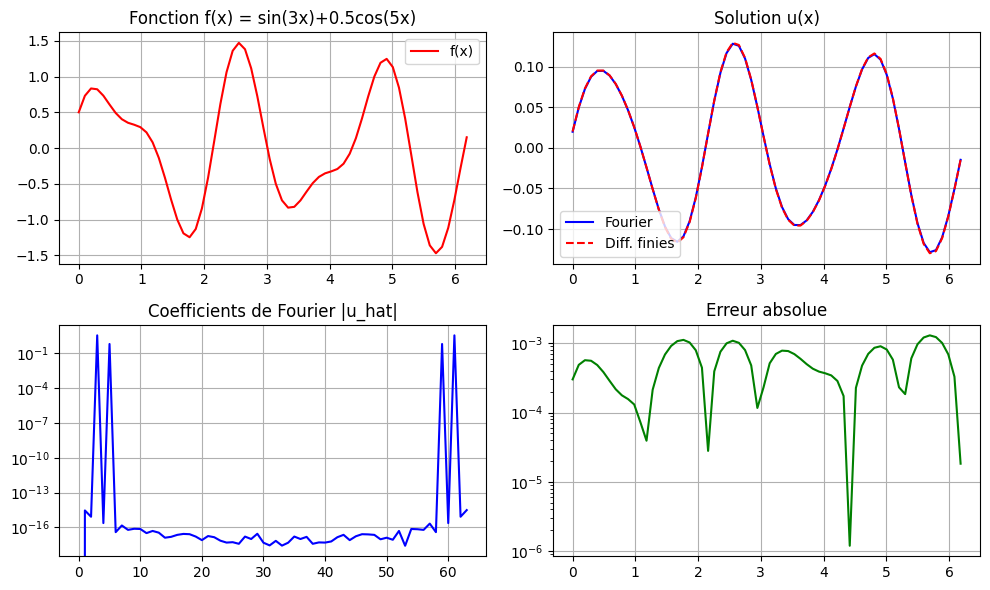


Test avec f(x) = exp(sin(x))
Erreur relative max: 1.05e+12


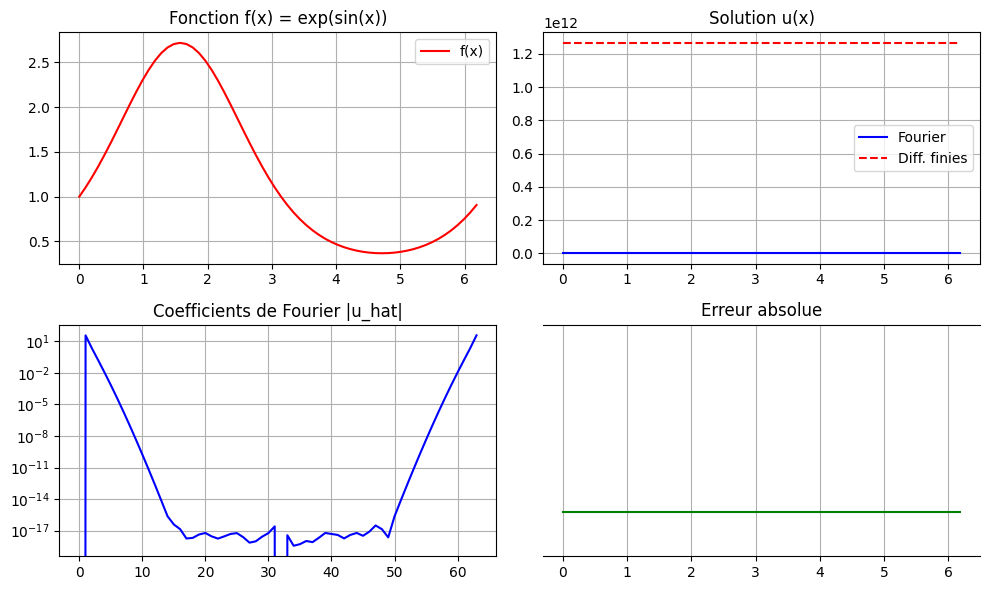

In [14]:
def solve_poisson_1d_fourier(f, N):
    """
    Résout -u'' = f sur [0, 2π] avec conditions périodiques
    en utilisant la série de Fourier

    f: fonction f(x)
    N: nombre de points de discrétisation
    """
    # Discrétisation
    x = np.linspace(0, 2*np.pi, N, endpoint=False)
    f_vals = f(x)

    # FFT de f
    f_hat = fft_non_recursive(f_vals)

    # Nombres d'onde
    k = np.fft.fftfreq(N) * N  # Equivalent pour notre FFT

    # Solution dans l'espace de Fourier
    # -u'' = f => (k^2) * u_hat = f_hat (pour k =/= 0)
    u_hat = np.zeros(N, dtype=complex)

    # Traitement séparé de la composante DC (k=0)
    # Pour k=0, l'équation est indéterminée, on choisit u_hat[0]=0
    for i in range(1, N):
        ki = k[i]
        # Éviter la division par zéro
        if abs(ki) > 1e-12:
            u_hat[i] = f_hat[i] / (ki**2)
        else:
            u_hat[i] = 0

    # Transformée inverse
    u = ifft_non_recursive(u_hat)

    return x, u.real, u_hat

def solve_poisson_1d_finite_difference(f, N):
    """
    Résout -u'' = f par différences finies
    avec discrétisation centrée du Laplacien
    """
    # Discrétisation
    x = np.linspace(0, 2*np.pi, N, endpoint=False)
    h = 2*np.pi / N
    f_vals = f(x)

    # Construction de la matrice circulante
    # -u'' ≈ (-u_{i-1} + 2u_i - u_{i+1})/h²
    c = np.zeros(N)
    c[0] = 2 / h**2
    c[1] = -1 / h**2
    c[-1] = -1 / h**2

    A = MatriceCirculante(c)

    # Résolution
    u = A.solve(f_vals)

    return x, u.real

def test_poisson_1d():
    """Test et comparaison des méthodes 1D"""

    # Définition de différentes fonctions f
    def f1(x):
        return np.sin(x)

    def f2(x):
        return np.sin(3*x) + 0.5*np.cos(5*x)

    def f3(x):
        return np.exp(np.sin(x))

    N = 64

    for i, (name, f) in enumerate([("sin(x)", f1),
                                    ("sin(3x)+0.5cos(5x)", f2),
                                    ("exp(sin(x))", f3)]):

        print(f"\nTest avec f(x) = {name}")

        # Solution par Fourier
        x_fourier, u_fourier, u_hat = solve_poisson_1d_fourier(f, N)

        # Solution par différences finies
        x_fd, u_fd = solve_poisson_1d_finite_difference(f, N)

        # Calcul de l'erreur relative
        error = np.max(np.abs(u_fourier - u_fd)) / np.max(np.abs(u_fourier))
        print(f"Erreur relative max: {error:.2e}")

        # Visualisation
        plt.figure(figsize=(10, 6))

        plt.subplot(2, 2, 1)
        plt.plot(x_fourier, f(x_fourier), 'r-', label='f(x)')
        plt.title(f'Fonction f(x) = {name}')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(x_fourier, u_fourier, 'b-', label='Fourier')
        plt.plot(x_fd, u_fd, 'r--', label='Diff. finies')
        plt.title('Solution u(x)')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.semilogy(np.abs(u_hat), 'b-')
        plt.title('Coefficients de Fourier |u_hat|')
        plt.grid(True)

        plt.subplot(2, 2, 4)
        diff = np.abs(u_fourier - u_fd)
        plt.semilogy(x_fourier, diff, 'g-')
        plt.title('Erreur absolue')
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'poisson_1d_test_{i+1}.png', dpi=100)
        plt.show()

test_poisson_1d()

## Exercice 4 : Problème 2D -Δu = f

=== Test FFT ===
Test FFT - N = 64
Temps custom: 0.000266 s
Temps scipy: 0.000095 s
Erreur maximale: 1.80e-14

Test Dirac - Erreur: 0.00e+00
Test aléatoire - Erreur: 1.59e-14

=== Test Matrices Circulantes ===
Test multiplication matrice-vecteur (direct): erreur = 1.78e-15
Test multiplication (FFT): erreur = 2.31e-15
Test valeurs propres: erreur = 4.15e-15
Test résolution Ax=b: erreur = 1.42e-15

=== Test Poisson 1D ===

Test avec f(x) = sin(x)
Erreur relative max: 8.16e-04


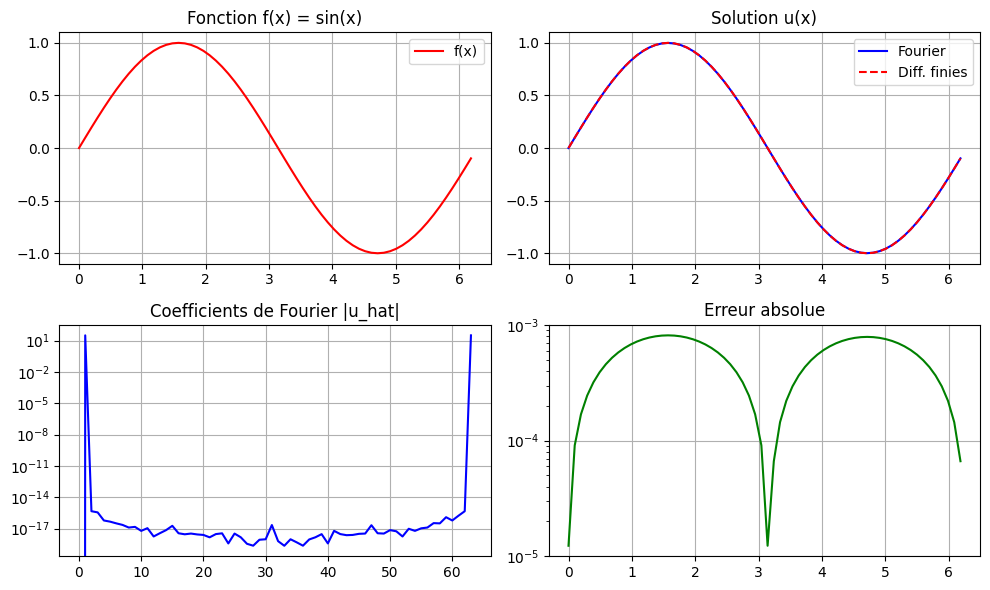


Test avec f(x) = sin(3x)+0.5cos(5x)
Erreur relative max: 1.01e-02


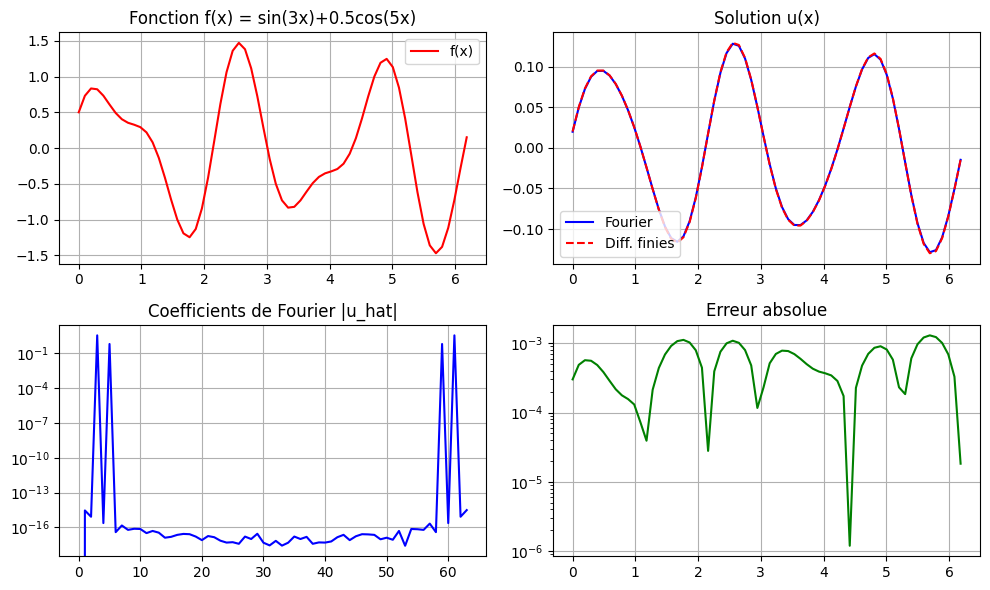


Test avec f(x) = exp(sin(x))
Erreur relative max: 1.05e+12


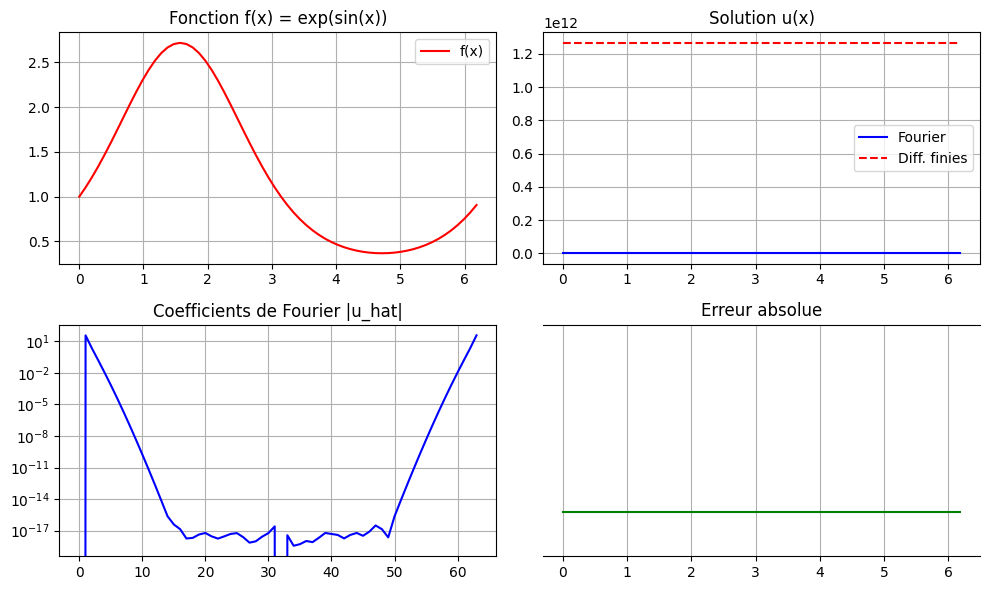


=== Test Poisson 2D ===

Test 2D avec f(x,y) = sin(2 pi x)sin(2 pi y)


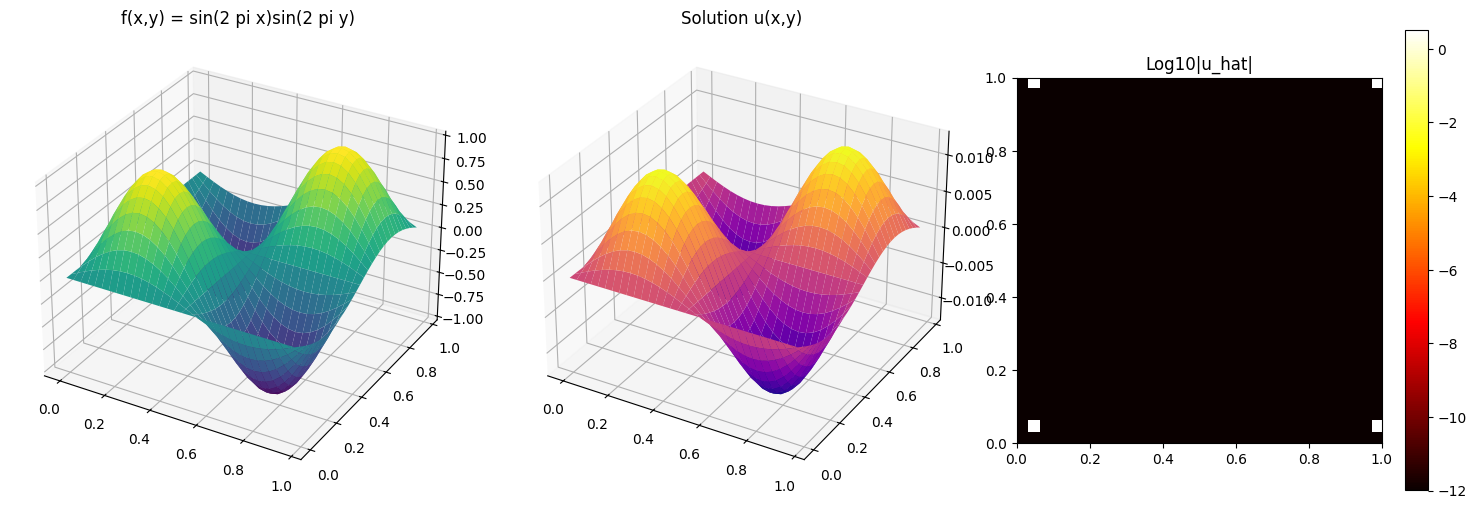

Résidu max: 3.21e-03

Test 2D avec f(x,y) = sin(4 pi x)cos(2 pi y)


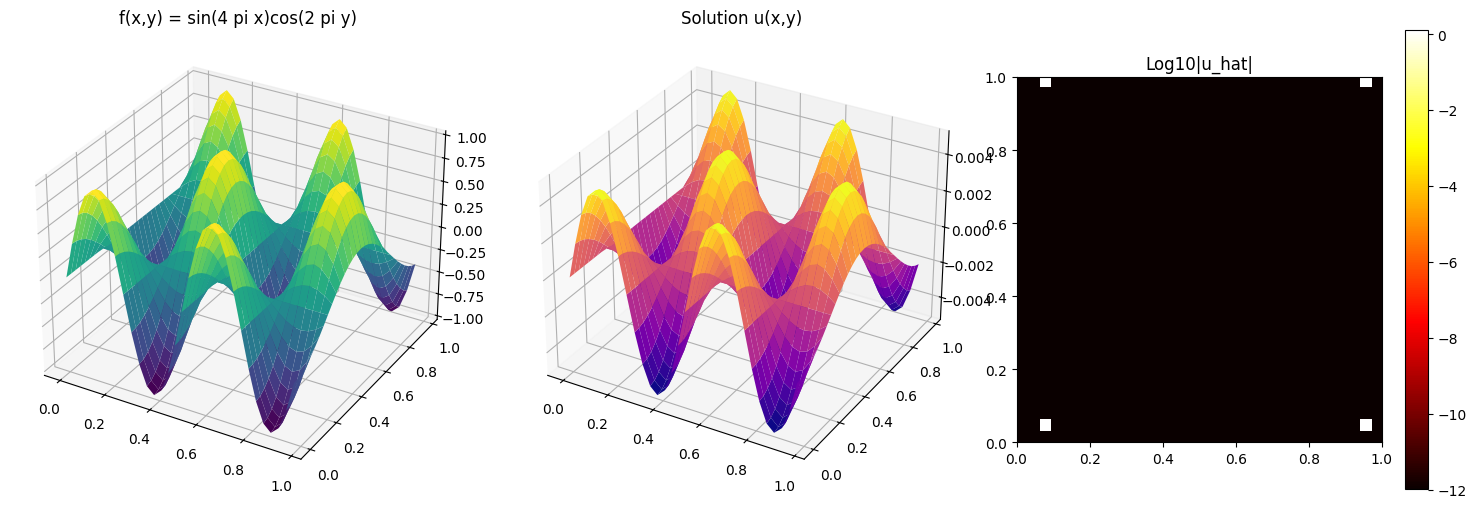

Résidu max: 1.09e-02

Test 2D avec f(x,y) = exp(sin(2 pi x)+cos(2 pi y))


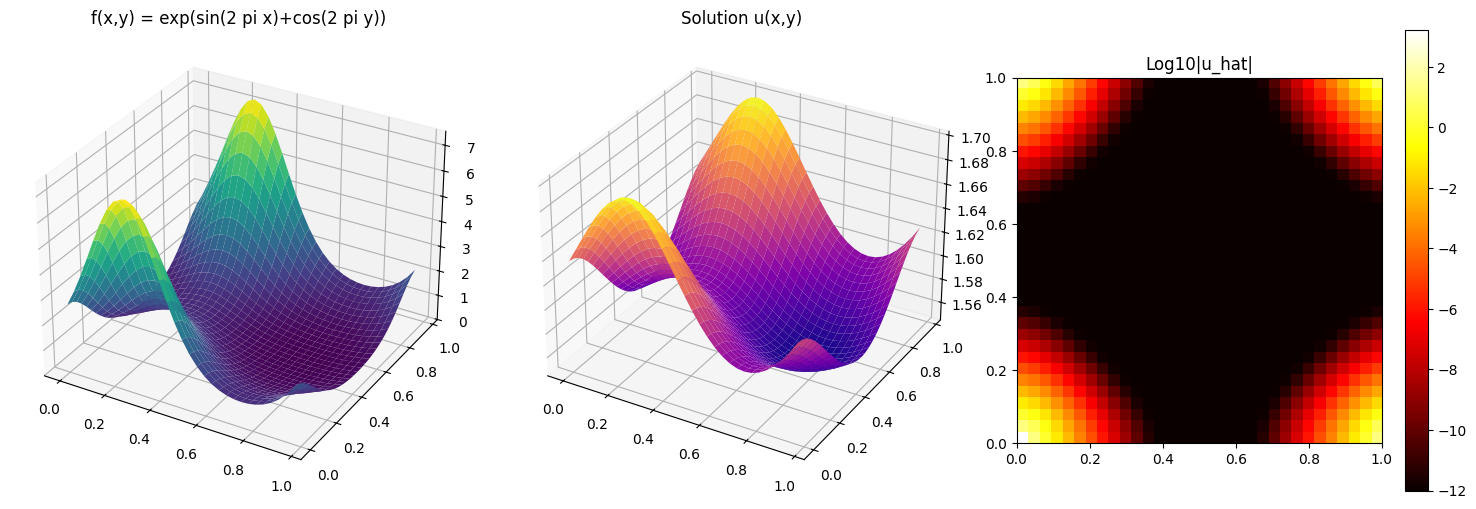

Résidu max: 1.64e+00


In [17]:
def solve_poisson_2d(f, Nx, Ny):
    """
    Résout -Δu = f sur [0,1]×[0,1] avec conditions périodiques
    en utilisant la méthode de différences finies et FFT

    f: fonction f(x,y)
    """
    # Grille
    x = np.linspace(0, 1, Nx, endpoint=False)
    y = np.linspace(0, 1, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y)

    f_vals = f(X, Y)


    hx = 1 / Nx
    hy = 1 / Ny


    kx = np.fft.fftfreq(Nx) * 2 * np.pi / hx
    ky = np.fft.fftfreq(Ny) * 2 * np.pi / hy

    KX, KY = np.meshgrid(kx, ky)


    L_hat = KX**2 + KY**2

    # Éviter la division par zéro pour la fréquence nulle
    L_hat[0, 0] = 1

    # FFT 2D de f (en utilisant notre FFT 1D ligne par ligne)
    f_hat = np.zeros((Ny, Nx), dtype=complex)
    for j in range(Ny):
        f_hat[j, :] = fft_non_recursive(f_vals[j, :])

    for i in range(Nx):
        f_hat[:, i] = fft_non_recursive(f_hat[:, i])

    u_hat = f_hat / L_hat

    # IFFT 2D
    u_intermediate = np.zeros((Ny, Nx), dtype=complex)
    for j in range(Ny):
        u_intermediate[j, :] = ifft_non_recursive(u_hat[j, :])

    u = np.zeros((Ny, Nx), dtype=complex)
    for i in range(Nx):
        u[:, i] = ifft_non_recursive(u_intermediate[:, i])

    return X, Y, u.real, u_hat

def test_poisson_2d():
    """Test du solveur Poisson 2D"""

    # Définition de différentes fonctions f
    def f1(x, y):
        return np.sin(2*np.pi*x) * np.sin(2*np.pi*y)

    def f2(x, y):
        return np.sin(4*np.pi*x) * np.cos(2*np.pi*y)

    def f3(x, y):
        return np.exp(np.sin(2*np.pi*x) + np.cos(2*np.pi*y))

    Nx, Ny = 32, 32

    for i, (name, f) in enumerate([("sin(2 pi x)sin(2 pi y)", f1),
                                    ("sin(4 pi x)cos(2 pi y)", f2),
                                    ("exp(sin(2 pi x)+cos(2 pi y))", f3)]):

        print(f"\nTest 2D avec f(x,y) = {name}")

        X, Y, u, u_hat = solve_poisson_2d(f, Nx, Ny)

        # Visualisation
        fig = plt.figure(figsize=(15, 5))

        # Fonction f
        ax1 = fig.add_subplot(131, projection='3d')
        ax1.plot_surface(X, Y, f(X, Y), cmap='viridis')
        ax1.set_title(f'f(x,y) = {name}')

        # Solution u
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.plot_surface(X, Y, u, cmap='plasma')
        ax2.set_title('Solution u(x,y)')

        # Coefficients de Fourier
        ax3 = fig.add_subplot(133)
        im = ax3.imshow(np.log10(np.abs(u_hat) + 1e-12),
                       extent=[0, 1, 0, 1],
                       cmap='hot',
                       origin='lower')
        plt.colorbar(im, ax=ax3)
        ax3.set_title('Log10|u_hat|')

        plt.tight_layout()
        plt.savefig(f'poisson_2d_test_{i+1}.png', dpi=100)
        plt.show()

        # Vérification de la solution (résidu)
        # Calcul approximatif du Laplacien par différences finies
        hx = 1 / Nx
        hy = 1 / Ny

        # Laplacien par différences finies centrées
        laplacien_u = np.zeros((Ny, Nx))
        laplacien_u[1:-1, 1:-1] = (
            (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1]) / hy**2 +
            (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2]) / hx**2
        )

        # Conditions aux limites périodiques
        # Bords verticaux
        laplacien_u[1:-1, 0] = (
            (u[2:, 0] - 2*u[1:-1, 0] + u[:-2, 0]) / hy**2 +
            (u[1:-1, 1] - 2*u[1:-1, 0] + u[1:-1, -1]) / hx**2
        )
        laplacien_u[1:-1, -1] = (
            (u[2:, -1] - 2*u[1:-1, -1] + u[:-2, -1]) / hy**2 +
            (u[1:-1, 0] - 2*u[1:-1, -1] + u[1:-1, -2]) / hx**2
        )

        # Bords horizontaux
        laplacien_u[0, 1:-1] = (
            (u[1, 1:-1] - 2*u[0, 1:-1] + u[-1, 1:-1]) / hy**2 +
            (u[0, 2:] - 2*u[0, 1:-1] + u[0, :-2]) / hx**2
        )
        laplacien_u[-1, 1:-1] = (
            (u[0, 1:-1] - 2*u[-1, 1:-1] + u[-2, 1:-1]) / hy**2 +
            (u[-1, 2:] - 2*u[-1, 1:-1] + u[-1, :-2]) / hx**2
        )

        # Coins
        for corner in [(0,0), (0,-1), (-1,0), (-1,-1)]:
            i, j = corner
            laplacien_u[i, j] = (
                (u[(i+1)%Ny, j] - 2*u[i, j] + u[(i-1)%Ny, j]) / hy**2 +
                (u[i, (j+1)%Nx] - 2*u[i, j] + u[i, (j-1)%Nx]) / hx**2
            )

        residu = np.max(np.abs(-laplacien_u - f(X, Y)))
        print(f"Résidu max: {residu:.2e}")


print("=== Test FFT ===")
test_fft()

print("\n=== Test Matrices Circulantes ===")
test_matrice_circulante()

print("\n=== Test Poisson 1D ===")
test_poisson_1d()

print("\n=== Test Poisson 2D ===")
test_poisson_2d()